In [15]:
!git clone https://github.com/ch2343/scCRAFT.git

fatal: destination path 'scCRAFT' already exists and is not an empty directory.


/Users/xiaoyushen/miniforge3/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [16]:
%cd scCRAFT
!pip install .

/Users/xiaoyushen/Desktop/biostat/lung_two_species/code/scCRAFT
Processing /Users/xiaoyushen/Desktop/biostat/lung_two_species/code/scCRAFT
  Preparing metadata (setup.py) ... done
  Created wheel for scCRAFT: filename=scCRAFT-1.0.0-py3-none-any.whl size=13804 sha256=aaa839c781cbb431da966df8db0a51be551b32d78647e42508361a1ff362811f
  Stored in directory: /private/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/pip-ephem-wheel-cache-k1j2xrhv/wheels/e7/e8/a8/d0c090a40a64e4b400c4d101a593bea6d4948222bba933dda0
Successfully built scCRAFT
  Attempting uninstall: scCRAFT
    Found existing installation: scCRAFT 1.0.0
    Uninstalling scCRAFT-1.0.0:
      Successfully uninstalled scCRAFT-1.0.0


In [ ]:
!pip install harmonypy

In [1]:
import scanpy as sc
import numpy as np
import scCRAFT
from scCRAFT.model import *
import harmonypy as hm
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import scanorama
import scanpy as sc
import scvi
import seaborn as sns
import torch
import scib
import louvain

/Users/sheena/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/sheena/Library/Python/3.9/lib/python/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


In [3]:
adata = anndata.read_h5ad("../Lung_two_species_raw.h5ad")
adata
# Assuming your AnnData object is named adata
adata.obs.rename(columns={'celltype': 'cell_type'}, inplace=True)
adata

AnnData object with n_obs × n_vars = 20760 × 62781
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sampleid', 'cellname', 'cell_type', 'species', 'batch', 'BATCH'
    var: 'genename-0', 'genename-1'

In [4]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
embeddings_dict = {}

# Scanorama

In [7]:
import anndata as ad

def split_batches(adata, batch_key, return_categories=False):
    """
    Split an AnnData object into a list of AnnData objects by batch.
    
    Parameters:
    - adata (AnnData): The AnnData object to split.
    - batch_key (str): The key in `adata.obs` used to identify batches.
    - return_categories (bool): Whether to return the unique categories (batch labels).

    Returns:
    - list: A list of AnnData objects, one for each batch.
    - list (optional): A list of unique batch categories, if `return_categories` is True.
    """
    if batch_key not in adata.obs:
        raise ValueError(f"Batch key '{batch_key}' not found in adata.obs.")
    
    categories = adata.obs[batch_key].unique().tolist()
    split_data = [adata[adata.obs[batch_key] == batch].copy() for batch in categories]
    
    if return_categories:
        return split_data, categories
    return split_data

In [8]:
#Scanorama
# Save original order of cells
original_order = adata.obs_names.copy()

# Your existing Scanorama correction process
split, categories = split_batches(adata.copy(), 'batch', return_categories=True)
corrected = scanorama.correct_scanpy(split, return_dimred=True)
corrected = anndata.AnnData.concatenate(
    *corrected, batch_key='batch', batch_categories=categories, index_unique=None
)

# Reorder corrected data to match original order
corrected = corrected[original_order]

# Replace adata with corrected data
adatas = corrected.copy()

Found 2000 genes among all datasets
[[0.         0.33522369]
 [0.         0.        ]]
Processing datasets (0, 1)


In [9]:
adata.obsm['X_scanorama'] = adatas.obsm['X_scanorama']

embeddings_dict['X_scanorama'] = adata.obsm["X_scanorama"]

In [10]:
embeddings_dict.keys()

dict_keys(['X_scVI', 'X_harmony', 'X_scCRAFT', 'X_seurat', 'X_scanorama'])

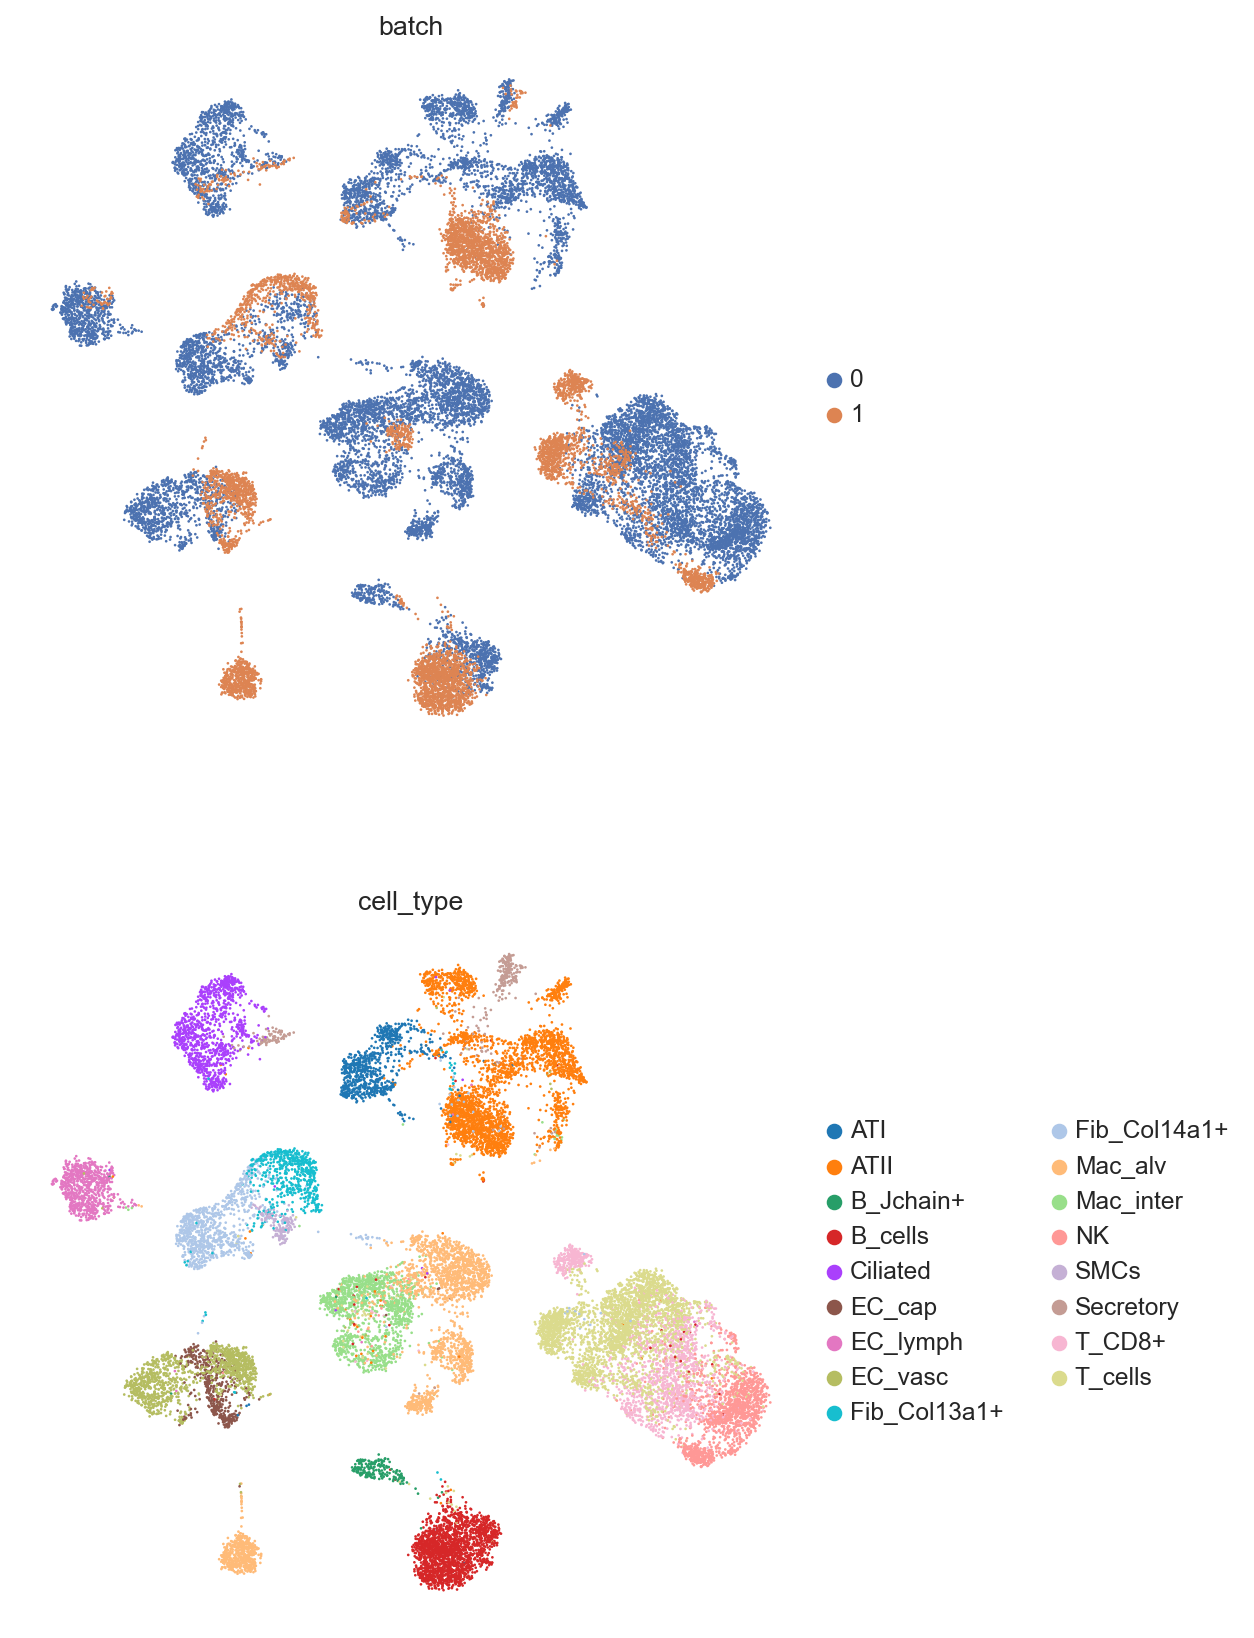

In [11]:
# Umap Plotting
sc.pp.neighbors(adata, n_pcs=30, use_rep="X_scanorama")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# scCRAFT

In [36]:
# scCRAFT
multi_resolution_cluster(adata, resolution1 = 1, method = 'Leiden')
VAE = train_integration_model(adata, batch_key = 'batch', z_dim=256, d_coef = 0.2)
obtain_embeddings(adata, VAE)
sc.pp.neighbors(adata, use_rep="X_scCRAFT")
sc.tl.umap(adata, min_dist=0.5)

150


Overall Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training completed in 62.61 seconds


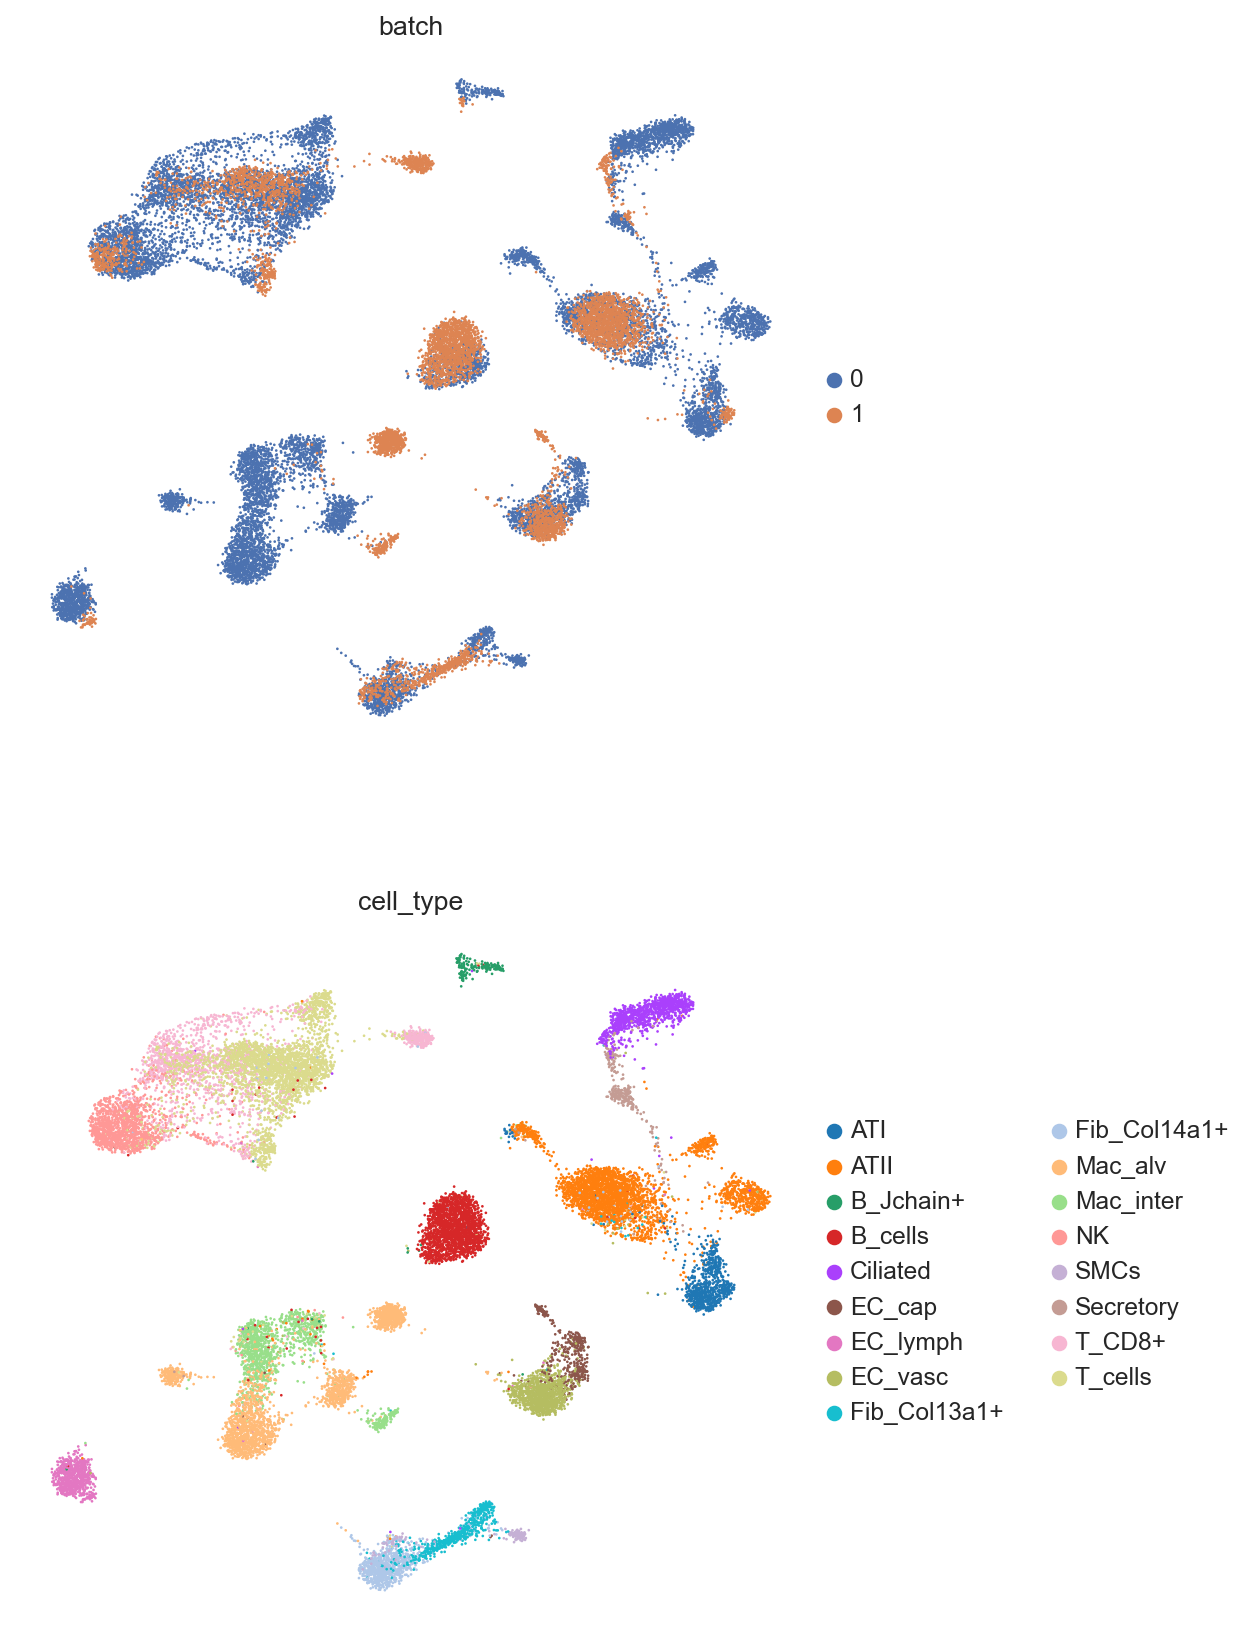

In [37]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [38]:
# Save embeddings
adata.obsm["X_scCRAFT"] = adata.obsm["X_scCRAFT"]

# Collect embeddings
embeddings_dict = {"X_scCRAFT": adata.obsm["X_scCRAFT"]}

# scVI

In [ ]:
# scVI
adata.layers['counts'] = adata.X
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [7]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

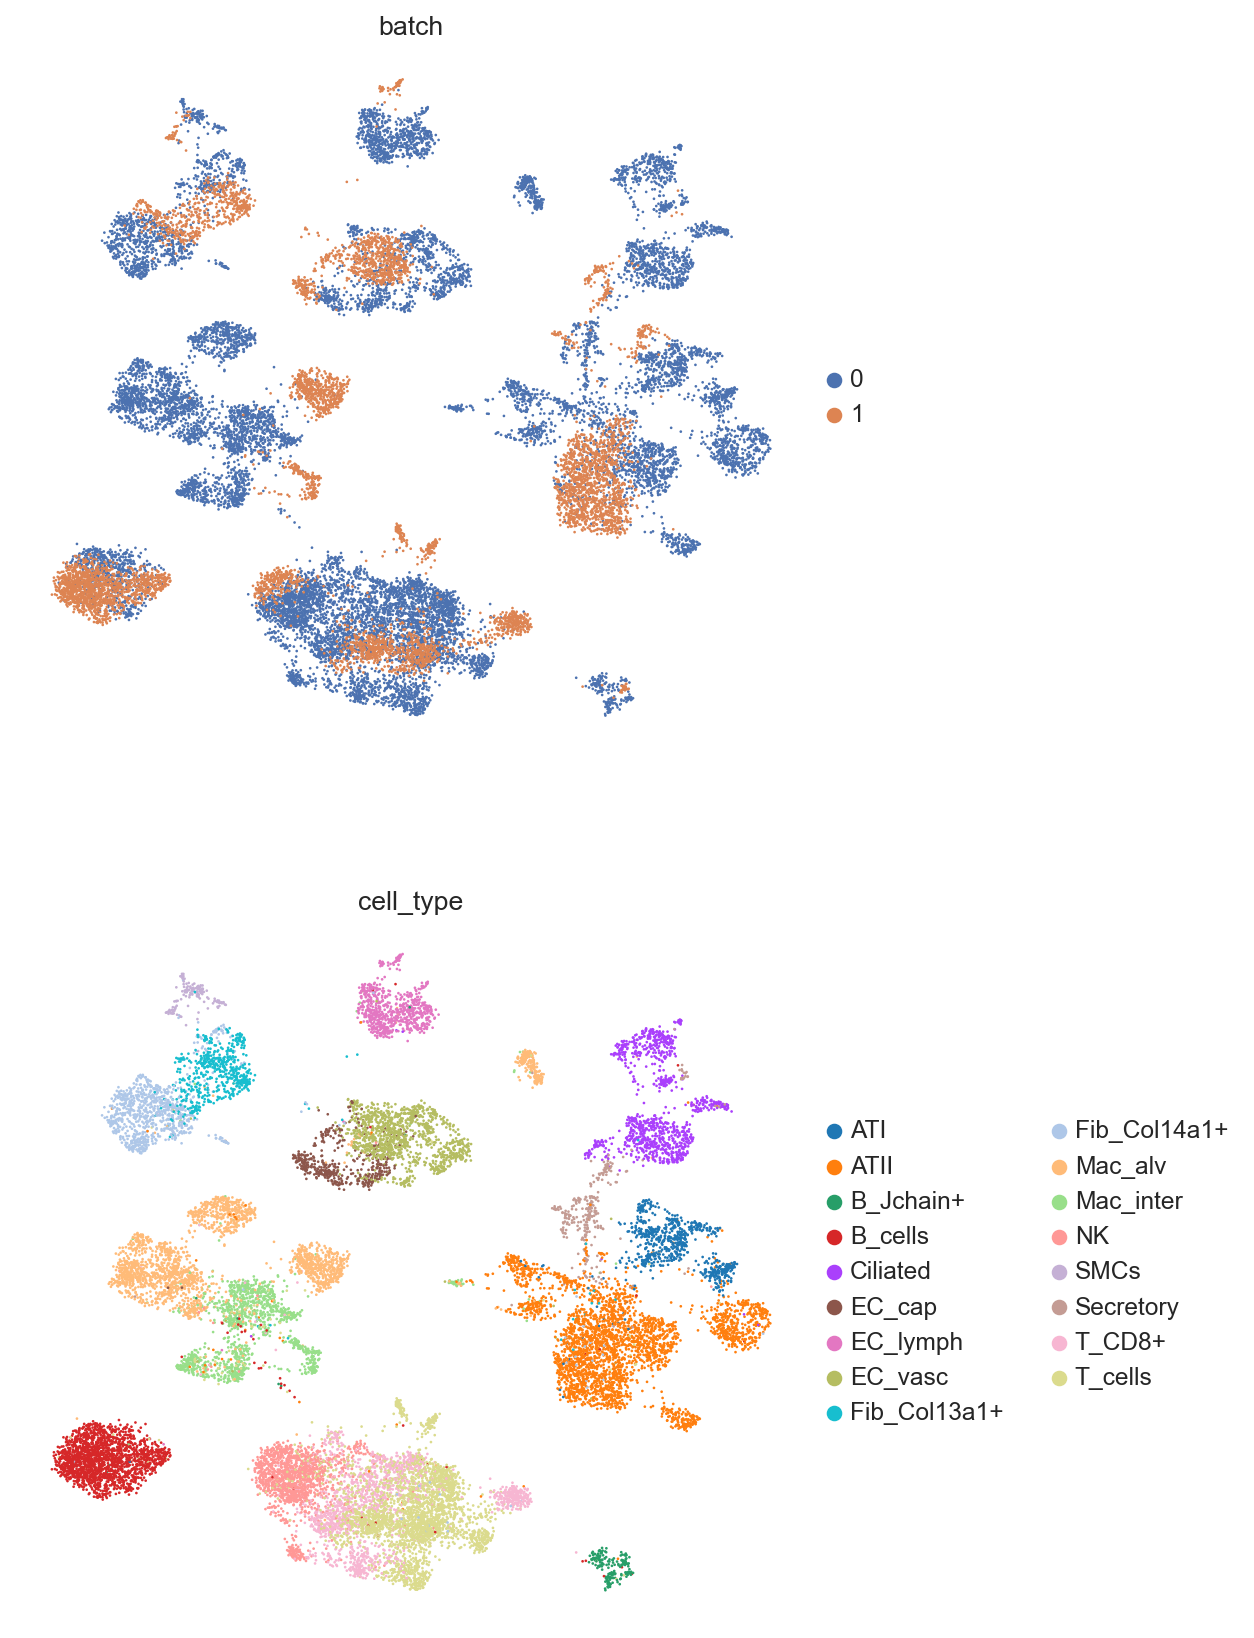

In [8]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# Harmony

In [9]:
# Harmony
sc.tl.pca(adata, n_comps=50)
data_mat = adata.obsm['X_pca']
meta_data = adata.obs

# Specify the variables to use (as in your original code)
vars_use = ['batch']

# Run Harmony
start_time = time.time()
ho = hm.run_harmony(data_mat, meta_data, vars_use)
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Convert the adjusted PCs to a DataFrame
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

# If you want to store the adjusted PCs back into the AnnData object
adata.obsm['X_harmony'] = res.values.T
sc.pp.neighbors(adata, use_rep="X_harmony")
sc.tl.umap(adata, min_dist=0.5)

2024-08-19 13:29:58,937 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-08-19 13:30:27,992 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-19 13:30:28,062 - harmonypy - INFO - Iteration 1 of 10
2024-08-19 13:30:34,341 - harmonypy - INFO - Iteration 2 of 10
2024-08-19 13:30:40,083 - harmonypy - INFO - Iteration 3 of 10
2024-08-19 13:30:46,330 - harmonypy - INFO - Iteration 4 of 10
2024-08-19 13:30:55,249 - harmonypy - INFO - Iteration 5 of 10
2024-08-19 13:31:02,244 - harmonypy - INFO - Iteration 6 of 10
2024-08-19 13:31:09,555 - harmonypy - INFO - Iteration 7 of 10
2024-08-19 13:31:16,705 - harmonypy - INFO - Iteration 8 of 10
2024-08-19 13:31:23,589 - harmonypy - INFO - Iteration 9 of 10
2024-08-19 13:31:31,189 - harmonypy - INFO - Iteration 10 of 10
2024-08-19 13:31:41,185 - harmonypy - INFO - Stopped before convergence


Training completed in 102.26 seconds


In [10]:
# Save embeddings
adata.obsm["X_harmony"] = adata.obsm["X_harmony"]

# Collect embeddings
embeddings_dict["X_harmony"] = adata.obsm["X_harmony"]

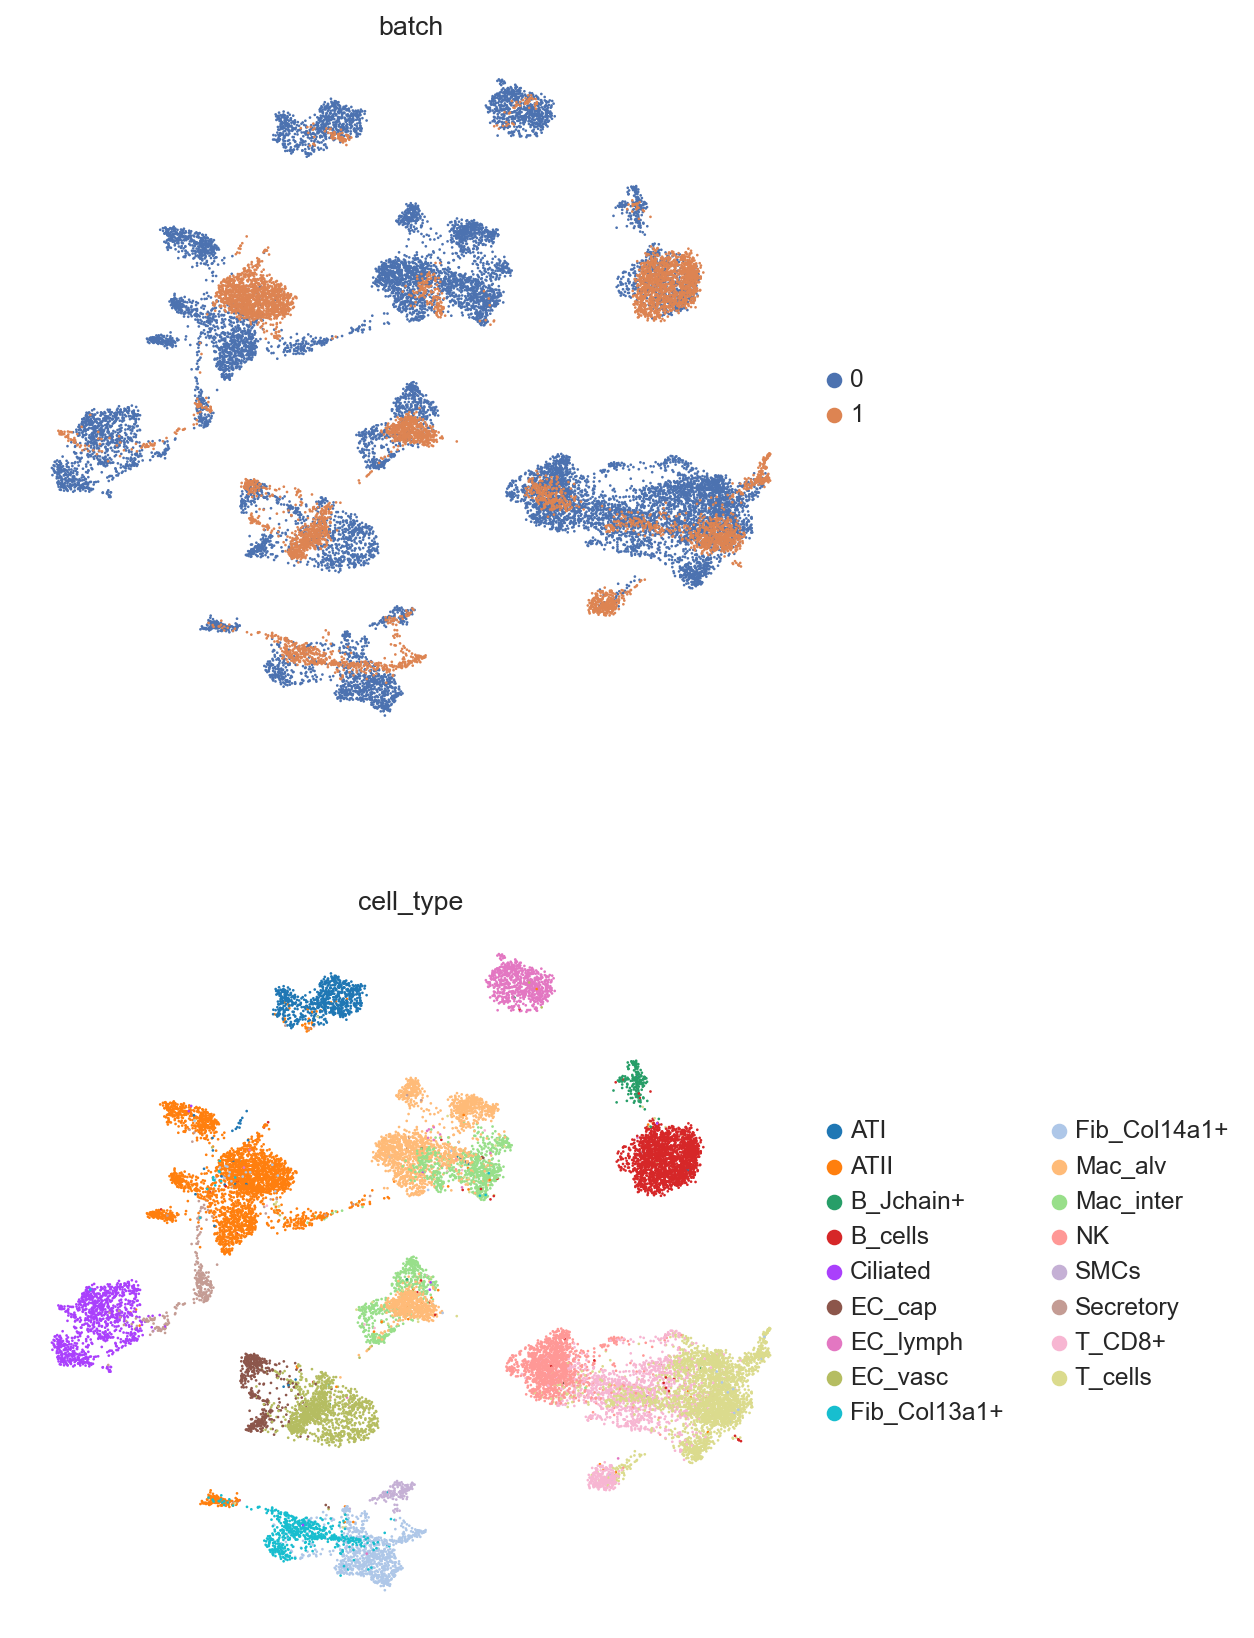

In [11]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# Seurat

In [6]:
pca_embeddings = pd.read_csv("../R_lung_two_species/embeddings/lung_two_species_seurat_embeddings.csv", index_col=0)
adata.obsm['X_seurat'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_seurat")
sc.tl.umap(adata, min_dist=0.5)

In [9]:
# Collect embeddings
embeddings_dict["X_seurat"] = adata.obsm["X_seurat"]

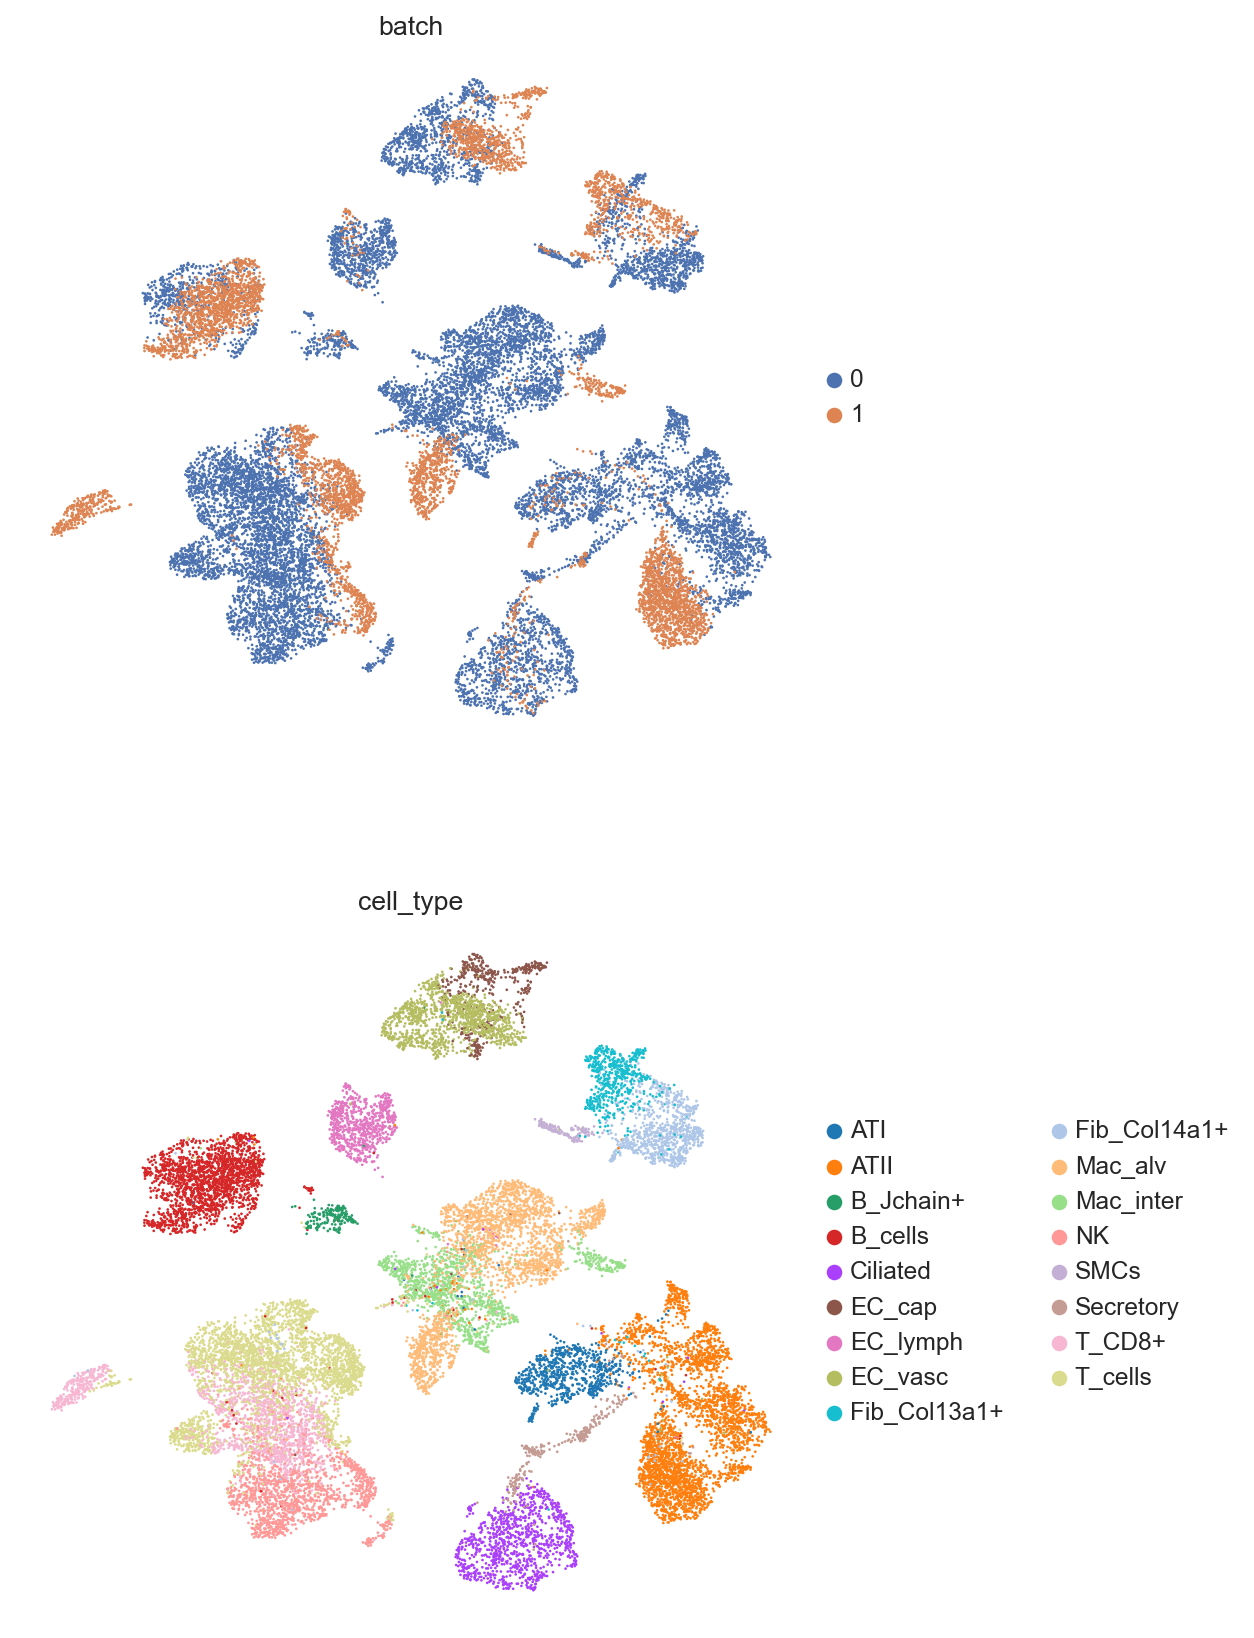

In [7]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [12]:
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/full_annotated_unsupervised_lung_two_species.csv")


# Metric Evaluation

## read the embeddings

In [6]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("../embeddings/full_annotated_unsupervised_lung_two_species.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scVI", "X_harmony", "X_scCRAFT", "X_seurat"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [13]:
sc.pp.neighbors(adata, use_rep="X_scVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True,isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scVI')

resolution: 0.1, nmi: 0.7924935637246607
resolution: 0.2, nmi: 0.7747186587264816
resolution: 0.3, nmi: 0.7816119930220915
resolution: 0.4, nmi: 0.7714003902531137
resolution: 0.5, nmi: 0.7680336102614188
resolution: 0.6, nmi: 0.7708971679918298
resolution: 0.7, nmi: 0.7708736198229544
resolution: 0.8, nmi: 0.7669743778261398
resolution: 0.9, nmi: 0.768116185710818
resolution: 1.0, nmi: 0.7487575788534868
resolution: 1.1, nmi: 0.7422754348647853
resolution: 1.2, nmi: 0.7412160233922326
resolution: 1.3, nmi: 0.7363848839158639
resolution: 1.4, nmi: 0.7388699165450819
resolution: 1.5, nmi: 0.7405505843992108
resolution: 1.6, nmi: 0.7379872141792732
resolution: 1.7, nmi: 0.737017362924985
resolution: 1.8, nmi: 0.7349511037882382
resolution: 1.9, nmi: 0.7354877291193969
resolution: 2.0, nmi: 0.7269045818103452
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.7924935637246607
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on 

In [14]:
sc.pp.neighbors(adata, use_rep="X_harmony")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True,graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True,isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_harmony')

resolution: 0.1, nmi: 0.7835248700038059
resolution: 0.2, nmi: 0.8037391286678748
resolution: 0.3, nmi: 0.8015476728465851
resolution: 0.4, nmi: 0.7991090806301664
resolution: 0.5, nmi: 0.7935452930958767
resolution: 0.6, nmi: 0.7899390351466314
resolution: 0.7, nmi: 0.7710499873365262
resolution: 0.8, nmi: 0.7688211139962321
resolution: 0.9, nmi: 0.7720790005427329
resolution: 1.0, nmi: 0.7670108913155217
resolution: 1.1, nmi: 0.7660180812959233
resolution: 1.2, nmi: 0.7641886739428388
resolution: 1.3, nmi: 0.7652316626224077
resolution: 1.4, nmi: 0.7647995244215947
resolution: 1.5, nmi: 0.7648142403669367
resolution: 1.6, nmi: 0.7663203516420419
resolution: 1.7, nmi: 0.7575233802702067
resolution: 1.8, nmi: 0.7572801765193331
resolution: 1.9, nmi: 0.7561436619074288
resolution: 2.0, nmi: 0.7494887714756374
optimised clustering against cell_type
optimal cluster resolution: 0.2
optimal score: 0.8037391286678748
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors o

In [15]:
sc.pp.neighbors(adata, use_rep="X_scCRAFT")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True,graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True,isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scCRAFT')

resolution: 0.1, nmi: 0.786670670257989
resolution: 0.2, nmi: 0.8041572861759834
resolution: 0.3, nmi: 0.7937329009457863
resolution: 0.4, nmi: 0.7886798336532123
resolution: 0.5, nmi: 0.786619839455316
resolution: 0.6, nmi: 0.7836739089671008
resolution: 0.7, nmi: 0.7866605515644768
resolution: 0.8, nmi: 0.7968618808583291
resolution: 0.9, nmi: 0.7977679679176561
resolution: 1.0, nmi: 0.7958035371493577
resolution: 1.1, nmi: 0.7962499000348257
resolution: 1.2, nmi: 0.7950408443156509
resolution: 1.3, nmi: 0.7941366699323222
resolution: 1.4, nmi: 0.7908423135921727
resolution: 1.5, nmi: 0.7895396581018215
resolution: 1.6, nmi: 0.7878121938005717
resolution: 1.7, nmi: 0.7895210588278833
resolution: 1.8, nmi: 0.7835600613610927
resolution: 1.9, nmi: 0.781893928934252
resolution: 2.0, nmi: 0.7834217626901017
optimised clustering against cell_type
optimal cluster resolution: 0.2
optimal score: 0.8041572861759834
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on r

In [12]:
sc.pp.neighbors(adata, use_rep="X_seurat")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df4_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True,graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True,isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_seurat')

resolution: 0.1, nmi: 0.7403871391940391
resolution: 0.2, nmi: 0.7562807432655801
resolution: 0.3, nmi: 0.7475073221286404
resolution: 0.4, nmi: 0.773647959108461
resolution: 0.5, nmi: 0.766061520650337
resolution: 0.6, nmi: 0.7637937671557216
resolution: 0.7, nmi: 0.7560575832978433
resolution: 0.8, nmi: 0.7610008549860443
resolution: 0.9, nmi: 0.755689139901536
resolution: 1.0, nmi: 0.7548520824912199
resolution: 1.1, nmi: 0.7564392140367122
resolution: 1.2, nmi: 0.7569806297978717
resolution: 1.3, nmi: 0.7511550915032255
resolution: 1.4, nmi: 0.7414234429906177
resolution: 1.5, nmi: 0.7399046917064579
resolution: 1.6, nmi: 0.7375790741359932
resolution: 1.7, nmi: 0.7358860564337744
resolution: 1.8, nmi: 0.7376206268608884
resolution: 1.9, nmi: 0.7306079756756475
resolution: 2.0, nmi: 0.7354325480090823
optimised clustering against cell_type
optimal cluster resolution: 0.4
optimal score: 0.773647959108461
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on re

In [16]:
# Adding new columns to each dataframe
df1_1['scVI'] = df1_1.iloc[:, 0]
df2_1['Harmony'] = df2_1.iloc[:, 0]
df3_1['scCRAFT'] = df3_1.iloc[:, 0]
df4_1['Seurat'] = df4_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scVI']]
df2_1 = df2_1[['Harmony']]
df3_1 = df3_1[['scCRAFT']]
df4_1 = df4_1[['Seurat']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1, df4_1], axis=1)

merged_df.to_csv("../metrics/lung_two_species_metrics_unsupervised.csv", index=True)

In [17]:
merged_df

,scVI,Harmony,scCRAFT,Seurat
NMI_cluster/label,0.789137,0.803850,0.808731,0.764373
ARI_cluster/label,0.592917,0.682092,0.593073,0.535594
ASW_label,0.578636,0.619405,0.600176,0.614285
ASW_label/batch,0.857767,0.837538,0.835347,0.611092
PCR_batch,NaN,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN,NaN
isolated_label_F1,0.832876,0.860047,0.839496,0.806709
isolated_label_silhouette,0.585027,0.617895,0.605085,0.614936
graph_conn,0.985357,0.964832,0.976643,0.944794
kBET,NaN,NaN,NaN,NaN
